In [1]:
# Parameters
from_date = "2022-12-15"
to_date = "2022-12-28"
token = "SOL"
connection_string = "sqlite:///data/data.db"


In [2]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

In [3]:
def hourly_return(df):
    return df.close/df.open-1

In [4]:
def vol_ohlc(df, lookback=10):
    df = df.sort_index()
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [5]:
def drawdown(df):
    df=df.sort_index()
    max_price=df.iloc[0]['high']
    drawdown=[0]
    for i in range(1, len(df)):
        current_drawdown = df.iloc[i]['low']/max_price-1
        drawdown.append(current_drawdown if (abs(current_drawdown)>abs(drawdown[-1])) else drawdown[-1])
        if df.iloc[i]['high']>max_price:
            max_price=df.iloc[i]['high']
        i+=1
    return drawdown

In [6]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [7]:
"""token = 'BTC'
from_date = '2022-11-07'
to_date = '2022-11-13'
connection_string = 'sqlite:///data.db'"""

"token = 'BTC'\nfrom_date = '2022-11-07'\nto_date = '2022-11-13'\nconnection_string = 'sqlite:///data.db'"

In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc_hw_cleaned 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)

In [9]:
prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)
prices = prices.sort_index()
prices['return'] = hourly_return(prices)
prices['volatility'] = vol_ohlc(prices)
prices['maximum_drawdown'] = drawdown(prices)

In [10]:
prices['day'] = prices.index.strftime("%m/%d/%Y").to_list()

In [11]:
events = prices[['day']]

In [12]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

In [13]:
series_plot(prices[['return']], events, ax=ax[0, 0])
series_plot(prices[['volatility']], events, ax=ax[0, 1])
series_plot(prices[['maximum_drawdown']], events, ax=ax[1, 0])
series_plot(prices[['close']], events, ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')

Text(0.5, 0.98, 'Market action for SOL between 2022-12-15 and 2022-12-28')

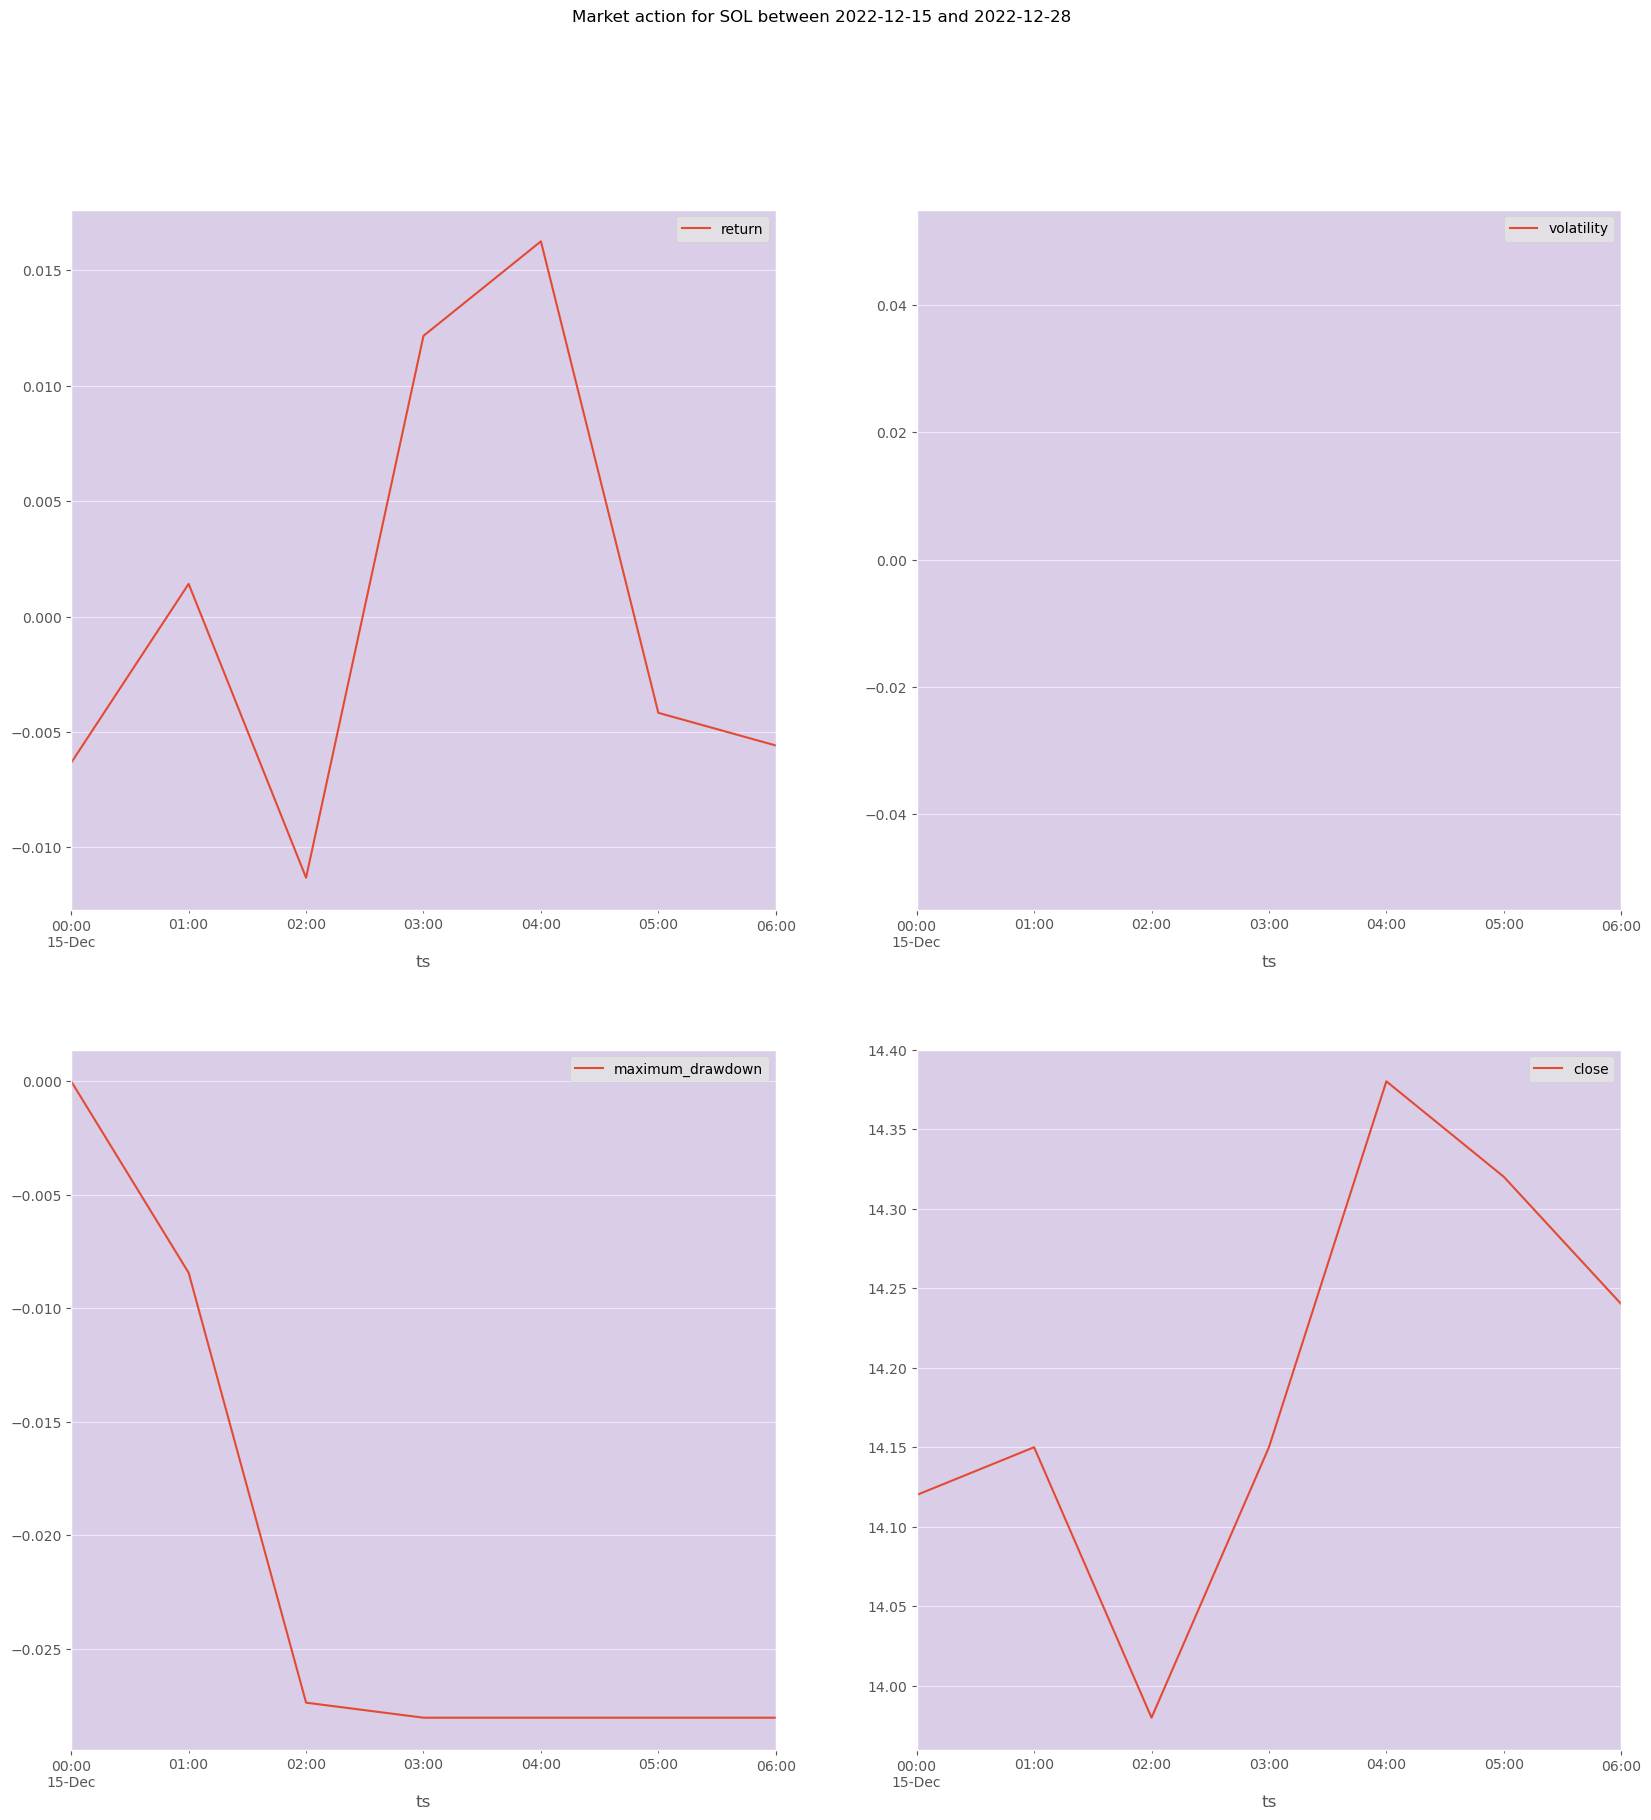

In [14]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)